<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[0] Mount Google Drive

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] Setting up Environment and Install Requirements

## 1.1 Set Working Directory, Install Requirements

In [3]:
import os
import sys
import gc

# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)


UsageError: Line magic function `%capture` not found (But cell magic `%%capture` exists, did you mean that instead?).


In [4]:
%%capture
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

## 1.2 Load and Initialize the Movie Registration Class

In [5]:
#Load Libraries

import pandas as pd
import numpy as np
import torch
from selenium import webdriver
from bs4 import BeautifulSoup
import re
from sources.ChinaFilm.Record_Registration import Registration # assume relative path at path_wd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
dy_reg = Registration(driver)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options


## 1.3 Load Latest Registration Publication

In [6]:
os.chdir('/content/drive/MyDrive/Github/Content/sources/ChinaFilm')
##########################################
# Use update_first=True to get latest records from China Film's Website
df = dy_reg.Refined_Records(update_first=False)

##########################################
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name,].reset_index(drop=True)
df_curr.columns
df_curr.head(2)

,电影类别,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,公示年,公示批次起始,类型,备案申请年份,备案立项年度顺序号,公示覆盖期间,公示覆盖天数
0,故事影片,影剧备字〔2021〕第2114号,侠胆医心之致命玄机,北京梦飞扬文化传播有限公司,芦战旗,同意拍摄,北京市,1920年，中部城市康城大学堂钱教授被人杀害，他有关石油的研究资料也被盗走。侠医方家铭和女警...,2021-08-06,国家电影局关于2021年6月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 6, 整月, 6, 整月)",故事片,2021,2114,"DatetimeIndex(['2021-06-01', '2021-06-02', '20...",30
1,故事影片,影剧备字〔2021〕第2041号,片羽,广州念兹影视传媒有限公司,柳,同意拍摄,广东省,出生贫困农村家庭的女孩小羽因心爱的漫画被毁与父亲断绝交流十余年，最后却发现是卑微的父亲用自己...,2021-08-06,国家电影局关于2021年6月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 6, 整月, 6, 整月)",故事片,2021,2041,"DatetimeIndex(['2021-06-01', '2021-06-02', '20...",30


In [7]:
df_curr['梗概']

0      1920年，中部城市康城大学堂钱教授被人杀害，他有关石油的研究资料也被盗走。侠医方家铭和女警...
1      出生贫困农村家庭的女孩小羽因心爱的漫画被毁与父亲断绝交流十余年，最后却发现是卑微的父亲用自己...
2      几位处在青春期的少年通过跳街舞参加比赛，在此过程中相互影响共同成长。最终赢下比赛，并收获了友...
3      优秀共产党员的后代肖建树带着激情来到深圳的热土谋生，跌宕之后才找准自己的定位；为了给家人的幸...
4      成功在于坚持，金廉在事业埋头苦干，成功的人都有一个好习惯就是有始有终，不轻易的放弃，金廉在创...
                             ...                        
264    桃桃在参加一个探险活动中发生意外，男友逸飞在活动视频回放中发现诸多疑点，想尽各种办法参加了下...
265    一次历经战火与磨难的出发，造就一个家庭在长征路上可歌可泣的历程。有人倒下，有人失散，有人终于...
266    参加成人高考失败的刘三省，为了混口饭吃只能去工地打工。在工地，他认识了一群淳朴善良，为了梦想...
267    明末，新皇赐当时武林第一高手李天寻青龙剑，让他为朝廷效力。李天寻却被恶人毒害，为何正贤所杀。...
268    大学毕业后的成瑶被分配到马镇神府革命烈士纪念馆担任管理员兼讲解员，成瑶都会被反复问及一个恼人...
Name: 梗概, Length: 269, dtype: string

## 1.4 Load Title Prediction Model

In [ ]:
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.to(device)
model.eval()

In [9]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
L = df_curr.shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [13]:
df_curr['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df_curr['预测片名'] = df_curr['预测片名'].apply(remove_specials)

In [15]:
df_curr['预测片名']

0        侠者无敌
1         漫画家
2      青春期的少年
3        深圳往事
4      成功在于坚持
        ...  
264      寻找桃桃
265      延安往事
266       好朋友
267       青龙剑
268       红艳艳
Name: 预测片名, Length: 269, dtype: object

## 1.5 Load Time Period and Genre Prediction

In [16]:
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset
from transformers import TrainingArguments, Trainer

In [17]:
path_wd = '/content/drive/MyDrive/Github/Content'
path_NRTA = '/content/drive/MyDrive/Github/Content/sources/NRTA'

In [18]:
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
id2label_time = {}
for k, v in label2id_time.items(): id2label_time[v] = k


label2id_genre= {'传奇': 0, '传记': 1, '其它': 2, '军旅': 3, '农村': 4, '宫廷': 5,  
                  '武打': 6, '涉案': 7, '神话': 8, '科幻': 9, '都市': 10, '青少': 11,
                  '革命': 12}
id2label_genre = {}
for k, v in label2id_genre.items(): id2label_genre[v] = k


In [19]:
# Genre Classifier

N_LABELS = len(id2label_genre)
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_curr.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_curr['类型'] = test_predictions
df_curr['类型'] = df_curr['类型'].apply(lambda x: id2label_genre[x])

In [21]:
# Genre Classifier

N_LABELS = len(id2label_time)
ID2LABEL = id2label_time
LABEL2ID = label2id_time

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAtime'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_curr.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_curr['年代'] = test_predictions
df_curr['年代'] = df_curr['年代'].apply(lambda x: id2label_time[x])

In [23]:
df_curr[['梗概', '类型', '年代']]

,梗概,类型,年代
0,1920年，中部城市康城大学堂钱教授被人杀害，他有关石油的研究资料也被盗走。侠医方家铭和女警...,传奇,近代
1,出生贫困农村家庭的女孩小羽因心爱的漫画被毁与父亲断绝交流十余年，最后却发现是卑微的父亲用自己...,都市,当代
2,几位处在青春期的少年通过跳街舞参加比赛，在此过程中相互影响共同成长。最终赢下比赛，并收获了友...,青少,当代
3,优秀共产党员的后代肖建树带着激情来到深圳的热土谋生，跌宕之后才找准自己的定位；为了给家人的幸...,都市,当代
4,成功在于坚持，金廉在事业埋头苦干，成功的人都有一个好习惯就是有始有终，不轻易的放弃，金廉在创...,都市,当代
...,...,...,...
264,桃桃在参加一个探险活动中发生意外，男友逸飞在活动视频回放中发现诸多疑点，想尽各种办法参加了下...,其它,当代
265,一次历经战火与磨难的出发，造就一个家庭在长征路上可歌可泣的历程。有人倒下，有人失散，有人终于...,革命,现代
266,参加成人高考失败的刘三省，为了混口饭吃只能去工地打工。在工地，他认识了一群淳朴善良，为了梦想...,都市,当代
267,明末，新皇赐当时武林第一高手李天寻青龙剑，让他为朝廷效力。李天寻却被恶人毒害，为何正贤所杀。...,武打,古代


# [2] Generating Article Contents

##[2.1] XXXX年XX月电影备案公示划重点

In [24]:
issue_name = df_curr.loc[0,'公示批次起始'][0] + '年' + df_curr.loc[0,'公示批次起始'][1] +'月'
issue_name += df_curr.loc[0,'公示批次起始'][2]

# Title
T1 = '{year}年'.format(year=df_curr.loc[0,'公示批次起始'][0])
T1 += '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  T1 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
T1 += '电影备案公示划重点'
print(T1)

2021年6月电影备案公示划重点


##[2.2] 	XXXX年XX月XX日,XX月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《熊猫传奇——黑洞之吻》,备案号为影特备字〔2021〕第006号,最近期的项目是《幕后英雄》,备案号为影剧备字〔2021〕第1360号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


In [25]:
# Obtain Variables
df_curr.loc[:,'公示日期'] = df_curr.loc[:,'公示日期'].astype('datetime64')
pub_year = df_curr.loc[0,'公示日期'].year
pub_month = df_curr.loc[0,'公示日期'].month
pub_day = df_curr.loc[0,'公示日期'].day
df_curr['备案申请年份'] = df_curr['备案申请年份'].astype('int')
df_curr_sorted = df_curr.sort_values(['备案申请年份', '备案立项年度顺序号'], ascending=True).reset_index(drop=True)
df_type = df_curr.groupby('电影类别')['电影类别'].count().sort_values(ascending=False).rename('数量').to_frame().reset_index()

# Write Content
T2 = '\t'
T2 += '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
T2 += '{month}月{part_of_month}的备案公示新鲜出炉！'.format(month=df_curr.loc[0,'公示批次起始'][1], part_of_month=df_curr.loc[0,'公示批次起始'][2])
T2 += '这一批次中，最遥远的项目是《{}》，'.format(df_curr_sorted.loc[0, '片名']) 
T2 += '备案号为{}，'.format(df_curr_sorted.loc[0, '备案立项号'])
T2 += '最近期的项目是《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
T2 += '备案号为{}。'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'])
T2 += '按备案类别划分本次完成备案的共计'
for i, row in df_type.iterrows():
  if i == df_type.shape[0]-1:
    T2 = T2.rstrip('、')
    T2 += '以及{type}{n}部。'.format(type=row['电影类别'], n=row['数量'])
  else:
    T2 += '{type}{n}部、'.format(type=row['电影类别'], n=row['数量'])
print(T2)

	2021年8月6日，6月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《迷你世界之觉醒》，备案号为影动备字〔2021〕第067号，最近期的项目是《老虎变成猫》，备案号为影剧备字〔2021〕第2154号。按备案类别划分本次完成备案的共计故事影片238部、科教影片15部、动画影片10部以及纪录影片6部。


## [2.3] 按类型划分，都市题材最多。

In [26]:
T3 = '\t'
T3 = '按类型划分，都市题材最多。'
df_genre_sorted = df_curr.groupby('类型')['片名'].count().sort_values(ascending=False).reset_index()
df_genre_sorted.columns = ['类型', '数量']

print(T3)

按类型划分，都市题材最多。


##[2.4] 按年代划分，当代题材占主力位置。

In [27]:
T4 = '\t'
T4 = '按年代划分，当代题材占主力位置。'
df_time_sorted = df_curr.groupby('年代')['片名'].count().sort_values(ascending=False).reset_index()
df_time_sorted.columns = ['年代', '数量']

print(T4)

按年代划分，当代题材占主力位置。


##[2.5] 	本批次中，大数据分析识别出XX部上市影视公司关联项目，占比XX%。慷田AI聚焦关注的有

In [28]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_curr.loc[df_curr['备案单位'].str.contains(pat_public), ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
df_focus

,电影类别,片名,备案单位,编剧,梗概,备案地
67,故事影片,一路囧到底,京唐儒意（厦门）影业有限公司,张文墨,讲述了京城豪门阔少徐良少爷遭女友莉莉遗弃后，情绪低落，独自前往厦门寻找莉莉。后在护士杨晓雨的...,福建省
111,故事影片,麻辣侦探,中视金策（北京）文化产业发展有限公司,赵秀利,"民国初期，东安市长利用职权与盗墓团伙勾结,想把中华民族文物倒卖到海外。为了中华的文物不外流，...",北京市
123,故事影片,似曾相识,嘉赞国际传媒（北京）有限公司、北京柏美亚洲文化发展中心有限公司,王永淳,常青偶遇了美丽的盲人姑娘杨天真，两人日久生情彼此产生了情愫。常青为了让心爱的姑娘不失去最佳的...,北京市
134,故事影片,营救,万达影业（长春）有限公司,柯贞年,女主持人侯子枫女儿被绑架，警方追踪调查，媒体争相报道。李中杰意外得知绑架案内幕，配合警方制服...,吉林省
187,动画影片,大鱼海棠贰,彼岸天（北京）文化有限公司、北京光线影业有限公司,梁旋,湫被灵婆复活，正式成为如升楼新任北斗。在履行职责的过程中湫结识了一位少年。两人一起同行，却卷...,北京市
190,纪录影片,寻找 花木兰,北京新光中视文化传媒有限公司内蒙古分公司、北京新光中视文化传媒有限公司、海南纪录影业有限公司,刘思沅,纪录影片以建党百年为主题，通过追寻中国人民解放军特级战斗英雄，现代花木兰郭俊卿的革命之旅，反...,内蒙古自治区
206,故事影片,英雄无畏,陕西广电影视文化产业发展有限公司、杭州东桥文化传媒有限公司、北京爱奇艺科技有限公司、北京奥创...,牛兴安,明德市公安局副局长杨栋在处理一起命案中，发现背后有涉黑势力作祟，遂带领警队深入调查，最终揭开...,陕西省
240,故事影片,喂喂喂足球队,上海田都影业有限公司、上海雍生投资咨询有限公司、北京泰禾视觉文化发展有限公司,龚应恬,11岁的喀什少年阿里甫.艾尔克是个盲人男孩儿，自身条件并不好，为了实现他的足球梦，报名参加了...,上海市
244,故事影片,惊叹号,上海儒意影视制作有限公司,苏彪,自幼热爱街舞的陈硕，从小到大都被人嘲笑没有街舞天赋，他通过多年的坚持与努力，终于入选浙江省街...,上海市
247,故事影片,妈妈在哪里,上海电影集团影视传媒有限公司,余红梅,子轩从小由奶奶带大，奶奶去世后，子轩成绩倒数第一，妈妈用尽办法甚至暴打子轩，使子轩陷入对学习...,上海市


In [29]:
pat_public

'中广|欢瑞|文投|苏宁|中视|吉视|吉翔|广厦|横店|中原|上海电影|大晟文化|泰禾|京西文化|北京文化|华数|中南|泛海|瀚叶|时代出版|世茂|中国电影|中影,|浙文|鹿港|东方明珠|当代文体|当代明诚|明诚|江苏有线|喜临门|当代|当代东方|电广传媒|湖南电广|祥源文化|祥源|皇氏|鼎龙|美盛|围海|宇顺|慈文|凯撒|中化岩土|中南|中南红|珠江|万达|浙富|国星|金逸|共达|同洲|奥飞|德力|思美|完美|东网|天威|华录百纳|华录|百纳|川网|华谊|新媒|捷成|中文在线|幸福蓝海|新文化|富春|亿通|唐德|浩洋|华策|数码视讯|平治|芒果|芒果超媒|丝路视觉|光线|台基|博汇|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'

In [31]:
ids = [134,187,206, 244,247]
df_focus_narrowed = df_curr.loc[ids, ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地', '类型', '年代', '预测片名']]
#ls_ptitles = []
#for content in df_focus_narrowed['梗概'].tolist():
#    ls_ptitles.append(''.join(autotitle.generate(content,1)).lower())
#ls_ptitles =  ['夺命主持', '北斗传说', '夺命命令', '舞动吧！少年', '妈妈再爱我一次']
#print(ls_ptitles)
########
T5 = '\t'
T5 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
T5 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
T5 += '结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了涉案、科幻、青少年及都市。\n'

"""
for _, row in df_focus_narrowed.iterrows():
  T5 += '\n《{name}》\n编剧：{writer}'.format(name=row['片名'],writer=row['编剧'])
  T5 += '\n备案单位：{co}'.format(co=row['备案单位'])
  T5 += '\n{synopsis}\n'.format(synopsis=row['梗概'])
"""
print(T5)

	本批次中，大数据分析识别出11部上市影视公司关联项目，占比4.09%。结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了涉案、科幻、青少年及都市。



In [ ]:
ls_ptitles

['夺命主持', '北斗传说', '夺命命令', '舞动吧！少年', '妈妈再爱我一次']

In [32]:
df_focus_narrowed

,电影类别,片名,备案单位,编剧,梗概,备案地,类型,年代,预测片名
134,故事影片,营救,万达影业（长春）有限公司,柯贞年,女主持人侯子枫女儿被绑架，警方追踪调查，媒体争相报道。李中杰意外得知绑架案内幕，配合警方制服...,吉林省,涉案,当代,女主持人
187,动画影片,大鱼海棠贰,彼岸天（北京）文化有限公司、北京光线影业有限公司,梁旋,湫被灵婆复活，正式成为如升楼新任北斗。在履行职责的过程中湫结识了一位少年。两人一起同行，却卷...,北京市,科幻,当代,如升楼
206,故事影片,英雄无畏,陕西广电影视文化产业发展有限公司、杭州东桥文化传媒有限公司、北京爱奇艺科技有限公司、北京奥创...,牛兴安,明德市公安局副局长杨栋在处理一起命案中，发现背后有涉黑势力作祟，遂带领警队深入调查，最终揭开...,陕西省,涉案,当代,追凶者
244,故事影片,惊叹号,上海儒意影视制作有限公司,苏彪,自幼热爱街舞的陈硕，从小到大都被人嘲笑没有街舞天赋，他通过多年的坚持与努力，终于入选浙江省街...,上海市,都市,当代,街舞少年
247,故事影片,妈妈在哪里,上海电影集团影视传媒有限公司,余红梅,子轩从小由奶奶带大，奶奶去世后，子轩成绩倒数第一，妈妈用尽办法甚至暴打子轩，使子轩陷入对学习...,上海市,青少,当代,妈妈再回来


##[2.6] 生成词云图
 Create Summary Word Cloud ImageImage

['营救', '大鱼海棠贰', '英雄无畏', '惊叹号', '妈妈在哪里', '女主持人', '如升楼', '追凶者', '街舞少年', '妈妈再回来']


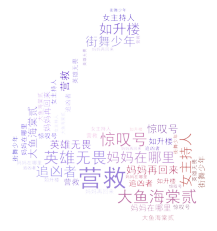

In [33]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/muscle-1085672_1280.png"
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'
ls = df_focus_narrowed['片名'].to_list() + df_focus_narrowed['预测片名'].to_list()
# highlights
print(ls)

mask = np.array(Image.open(path_image)) # 定义词频背景
wc = wordcloud.WordCloud(

    font_path=path_font,
    mask=mask, # set back ground mask image
    max_words=44,
    max_font_size=144,
    background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    repeat=True,
)
wc.generate(','.join(ls))

image_colors = wordcloud.ImageColorGenerator(mask)
wc.recolor(color_func=image_colors)
plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show()

wc.to_file(path_img + '/img_title_' + issue_name + '.png')

##[2.7] 生成摘要
2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。

In [34]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['备案单位'].str.extract('('+ pat_public + ")")
df_f = df_focus_narrowed.groupby('单位简称')['片名'].apply(
    lambda x: '、'.join('《' + x + '》')).rename('关注影片').reset_index()
#####
S0 = '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
S0 +=  '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  S0 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
S0 += '的电影备案公示发布，其中'
S0 += '最遥远的是{}的《{}》，'.format(df_curr_sorted.loc[0, '备案立项号'], df_curr_sorted.loc[0, '片名'])
S0 += '最近期的是{}的《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, 
                                                 '备案立项号'], df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
S0 += '慷田AI聚焦关注的项目有'
for i, row in df_f.iterrows():
  if i == df_f.shape[0]-1:
    S0 = S0.rstrip('、')
    S0 += '以及{co}的{film}'.format(co=row['单位简称'], film=row['关注影片'])
  else:
    S0 += '{co}的{film}、'.format(co=row['单位简称'], film=row['关注影片'])
S0 += '。'
print(S0)

2021年8月6日，6月的电影备案公示发布，其中最遥远的是影动备字〔2021〕第067号的《迷你世界之觉醒》，最近期的是影剧备字〔2021〕第2154号的《老虎变成猫》，慷田AI聚焦关注的项目有万达的《营救》、上海电影的《妈妈在哪里》、儒意的《惊叹号》、光线的《大鱼海棠贰》以及爱奇艺的《英雄无畏》。


##[2.8] 指向电影剧官网


In [35]:
#####
T6 = '\n\n'
T6 += '\t慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
T6 += '电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址 '
T6 += ' http://www.chinafilm.gov.cn/chinafilm 。'

print(T6)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。


#[3] Output Word Document

## 3.1 Install and Load Libraries

In [ ]:
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

     |████████████████████████████████| 5.6 MB 4.3 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184508 sha256=a1a34aed7a89634c67e1a554528b9a54d47b5797b3768d61a8edd4ad16a2a508
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [ ]:
df_focus

## 3.2 Output Docx


In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'China Movie Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)

doc.add_paragraph(T3)
table_genre = doc.add_table(rows=1, cols=2, style='Light List Accent 4', width=Inches(2.5))
for _, row in df_genre_sorted.iterrows():
  row_cells = table_genre.add_row().cells
  row_cells[0].text = row['类型']
  row_cells[1].text = str(row['数量'])


doc.add_paragraph(T4)
table_time = doc.add_table(rows=1, cols=2, style='Light List Accent 4', width=Inches(2.5))
for _, row in df_time_sorted.iterrows():
  row_cells = table_time.add_row().cells
  row_cells[0].text = row['年代']
  row_cells[1].text = str(row['数量'])

doc.add_paragraph(T5)

doc.add_picture(path_img + '/img_title_' + issue_name + '.png', width =Inches(3))


table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = '类型:{}  年代:{}'.format(row['类型'], row['年代'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(T6)

doc.save(path_doc + '/overview_' + issue_name + '.docx' )


NameError: ignored

# 【4】


In [ ]:
print(df_curr['电影类别'].unique())
print(df_curr['类型'].unique())

<StringArray>
['故事影片', '科教影片', '纪录影片', '动画影片']
Length: 4, dtype: string
['传奇' '都市' '青少' '其它' '革命' '农村' '涉案' '科幻' '神话' '军旅' '武打']


In [ ]:
from IPython.display import display, HTML
df_chart = df_curr[['片名', '编剧','备案单位', '梗概', '类型', '年代', '电影类别']]
df_chart = df_chart[df_chart.电影类别 == '故事影片']
df_chart[df_chart.类型 == '传奇' ].to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>片名</th>\n      <th>编剧</th>\n      <th>备案单位</th>\n      <th>梗概</th>\n      <th>类型</th>\n      <th>年代</th>\n      <th>电影类别</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>侠胆医心之致命玄机</td>\n      <td>芦战旗</td>\n      <td>北京梦飞扬文化传播有限公司</td>\n      <td>1920年，中部城市康城大学堂钱教授被人杀害，他有关石油的研究资料也被盗走。侠医方家铭和女警探乔青青联手破案。经过重重艰难，他们找到了杀害钱教授的真凶，并粉碎了日本间谍妄图窃取中国石油机密的阴谋。</td>\n      <td>传奇</td>\n      <td>近代</td>\n      <td>故事影片</td>\n    </tr>\n    <tr>\n      <th>51</th>\n      <td>铜钱龛世</td>\n      <td>韩笑</td>\n      <td>爱你影业（海南）有限公司、爱你影业（北京）有限公司、天空影业（天津）有限公司、合肥亚寰影业有限公司、北京中联顺合投资管理有限公司</td>\n      <td>一身傲骨、倜傥不群的明轩因身怀至宝遭人暗害藏身于慕氏荒宅中养伤，一次误打误撞让他与心地纯善、胸怀天下的天智意外结缘。二人志同道合，结伴同行，历尽艰险，携手为百姓惩奸除恶，行侠仗义，潇洒世间。</td>\n      <td>传奇</td>\n      <td>古代</td>\n      <td>故事影片</td>\n    </tr>\n    <tr>\n      <th>54</th>\n      <td>武士</td>\n      <td>陆磊</td>\n      <td>河南翼蓝影视文化传媒有限公司</td>\n      